In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import catboost as ctb
from bayes_opt import BayesianOptimization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
   

В данном соревновании имеются два вида данных: табличные и картинки.
   Проанализируем табличные данные и построим на них первый бейзлайн.

In [2]:
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [3]:
train['target'].value_counts() #дисбаланс классов

0    32542
1      584
Name: target, dtype: int64

In [4]:
train['target'].value_counts(normalize=True)

0    0.98237
1    0.01763
Name: target, dtype: float64

In [5]:
#проверим отсутствие пустых значений
train.isnull().sum() 

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

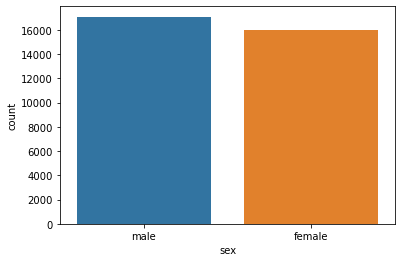

In [6]:
sns.countplot(data=train, x='sex') 
# существенной разницы по количеству мужчин и женщин не видно

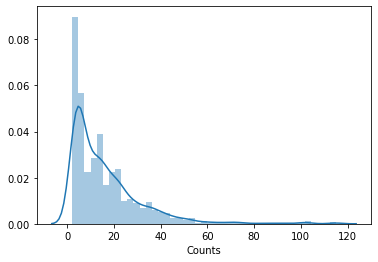

In [7]:
patient = train['patient_id'].value_counts()
sns.distplot(patient, axlabel='Counts', label='Frequency')

#для многих пациентов мы имеем несколько наблюдений

Text(0.5, 1.0, 'Malignant cases in train')

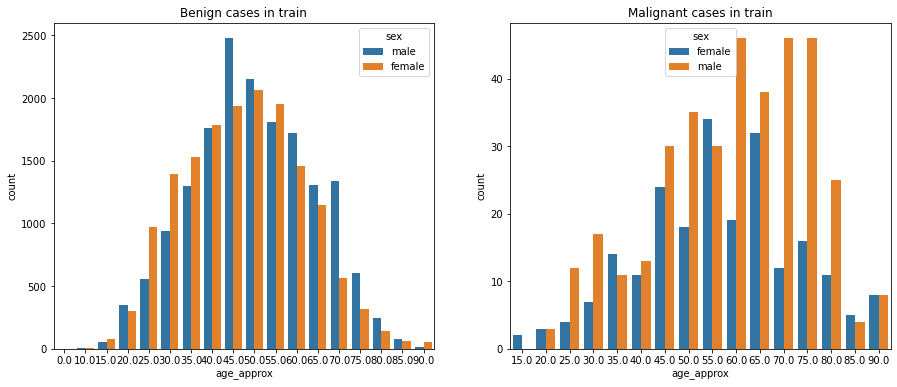

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))
sns.countplot(data=train.loc[train['target']==0], x='age_approx', hue="sex", ax=ax[0]) 
ax[0].set_title("Benign cases in train");
sns.countplot(data=train.loc[train['target']==1], x='age_approx', hue="sex", ax=ax[1]) 
ax[1].set_title("Malignant cases in train")

#в части данных отсутствует и возраст и пол
#вероятность злокачественного образования повышается у мужчин 70-75 лет

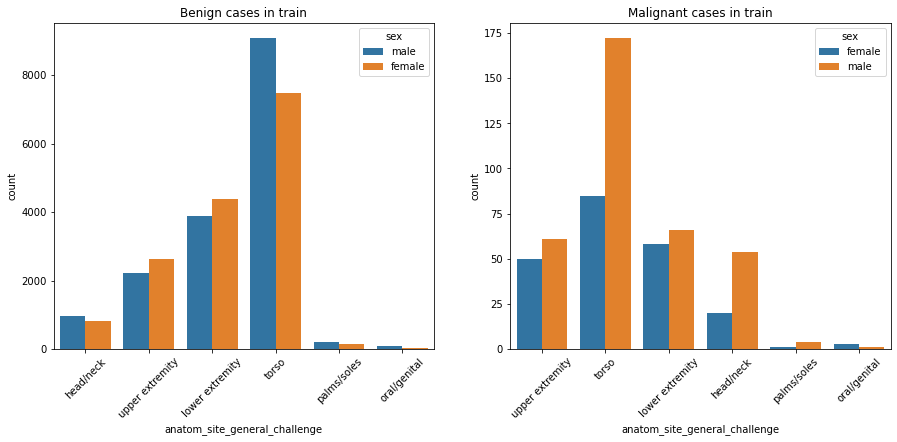

In [9]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))
sns.countplot(data=train.loc[train['target']==0], x='anatom_site_general_challenge', hue="sex", ax=ax[0]) 
ax[0].set_title("Benign cases in train")
ax[0].tick_params(axis='x', rotation=45)
sns.countplot(data=train.loc[train['target']==1], x='anatom_site_general_challenge', hue="sex", ax=ax[1]) 
ax[1].set_title("Malignant cases in train")
ax[1].tick_params(axis='x', rotation=45)

#у мужчин злокачественные новообразования встречаются чаще

In [10]:
train['sex'] = train['sex'].fillna('na')
train['age_approx'] = train['age_approx'].fillna(0)
train['anatom_site_general_challenge'] = train['anatom_site_general_challenge'].fillna('na')

In [11]:
#выделим возраст первого и последнего наблюдения для каждого пациента
train['age_id_min'] = train['patient_id'].map(train.groupby(['patient_id']).age_approx.min())
train['age_id_max'] = train['patient_id'].map(train.groupby(['patient_id']).age_approx.max())


In [12]:
train.loc[train['age_id_min'] != train['age_id_max']]['target'].value_counts(normalize=True)

0    0.979952
1    0.020048
Name: target, dtype: float64

In [13]:
train.loc[train['age_id_min'] == train['age_id_max']]['target'].value_counts(normalize=True)
#делаем предположение, что вероятность злокачественного образования больше, если пациент обследовался повторно

0    0.984803
1    0.015197
Name: target, dtype: float64

In [14]:
#добавим среднее значение цвета изображения https://www.kaggle.com/awsaf49/mean-color-isic2020/
train_mean_color = pd.read_csv('/kaggle/input/mean-color-isic2020/train_color.csv')
train['mean_color'] = train_mean_color.values

In [15]:
#save
train.to_csv('train_all.csv')


In [16]:
#так как данные очень не сбалансированные, мы возьмем только часть отрицательных случаев

df_0 = train[train['target']==0].sample(3000, random_state=1)
df_1 = train[train['target']==1]
train = pd.concat([df_0,df_1])
train = train.reset_index()
train['target'].value_counts(normalize=True)

0    0.837054
1    0.162946
Name: target, dtype: float64

In [17]:
#создадим отложенную выборку
feat=['anatom_site_general_challenge', 'sex', 'age_approx', 'age_id_min', 'age_id_max', 'mean_color']
train, test, y_train, y_test = train_test_split(train[feat], train['target'], test_size=0.2, random_state=42)

In [18]:
#соотношение классов осталось преждним
y_train.value_counts(normalize=True)

0    0.831531
1    0.168469
Name: target, dtype: float64

In [19]:
#преобразуем текстовые ячейки в категориальные переменные и добавим численные переменные

encoder = OrdinalEncoder()
train_data = encoder.fit_transform(train[['anatom_site_general_challenge', 'sex']])
train_data = np.concatenate((train_data, np.array(train[['age_approx', 'age_id_min', 'age_id_max', 'mean_color']])), axis=1)

test_data = encoder.transform(test[['anatom_site_general_challenge', 'sex']])
test_data = np.concatenate((test_data, np.array(test[['age_approx', 'age_id_min', 'age_id_max', 'mean_color']])), axis=1)

train_df = pd.DataFrame(train_data, columns=[['anatom_site_general_challenge', 'sex', 'age_approx', 'age_id_min', 'age_id_max', 'mean_color']])

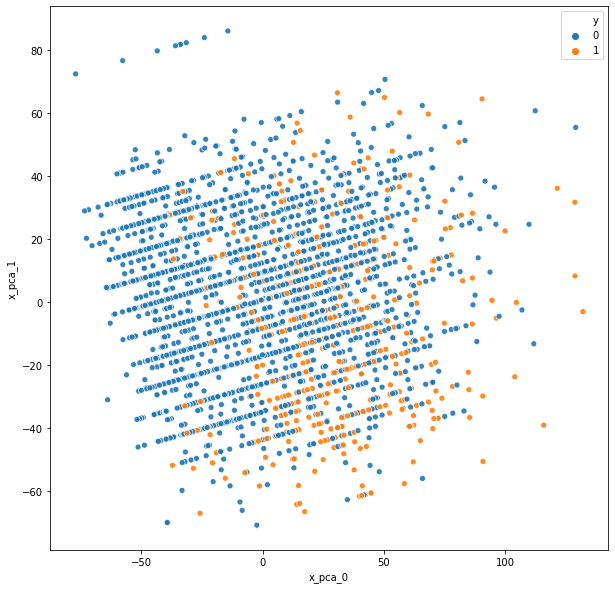

In [20]:
#Попробуем визуализировать классы в двумерном пространстве

from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(train_data)

pca_df = pd.DataFrame({'x_pca_0':X_pca[:,0],
             'x_pca_1':X_pca[:,1],
             'y':y_train})

plt.figure(figsize = (10,10))
sns.scatterplot(
    x="x_pca_0", y="x_pca_1",
    hue="y",
    data=pca_df,
    legend="full",
    alpha=0.9
)

#линейно выделить классы нельзя, но при этом замете сдвиг первого класса в правую сторону

In [21]:
train_data.shape

(2867, 6)

In [22]:
#отмасштабируем данные и проведем кросс-валидацию логистической регрессии
kfold = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(random_state=42))])
cross_val_score(pipe_lr, train_data, y_train, cv=kfold, scoring="roc_auc")


array([0.76917848, 0.75159967, 0.78736486])

In [46]:
#подберем параметры для логистической регрессии
param_grid = { 
    'lr__C': [0.5, 1, 5],
    'lr__penalty': ['l1', 'l2', 'elasticnet']
}

CV_lr = GridSearchCV(estimator=pipe_lr, param_grid=param_grid, cv=kfold, scoring="roc_auc")
CV_lr.fit(train_data, y_train)
print(CV_lr.best_params_)
print(CV_lr.best_score_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/pyt

{'lr__C': 5, 'lr__penalty': 'l2'}
0.7696388716118312


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/opt/conda

In [24]:
#посмотрим значение метрики
metrics =  {}
metrics['LR'] = roc_auc_score(y_test, CV_lr.predict_proba(test_data)[:,1])
print(metrics['LR'])

0.7874662466246625


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, CV_lr.predict(test_data), digits=4))

              precision    recall  f1-score   support

           0     0.8721    0.9854    0.9253       616
           1     0.5714    0.1188    0.1967       101

    accuracy                         0.8633       717
   macro avg     0.7218    0.5521    0.5610       717
weighted avg     0.8298    0.8633    0.8227       717



In [26]:
#попробуем улучшить результат, используя деревья решений
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(train_df, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

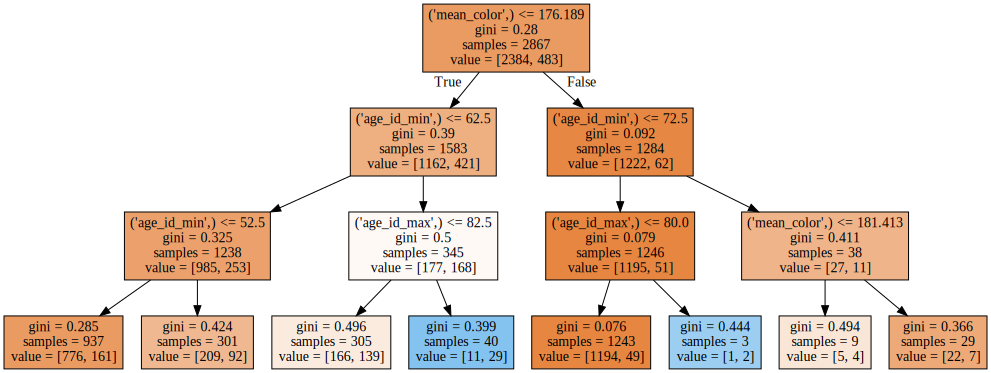

In [27]:
#визуализируем дерево
import graphviz 
from graphviz import Source
from sklearn import tree
dot_data = tree.export_graphviz(tree_clf, out_file='tree.dot', feature_names=train_df.columns, filled=True)
Source.from_file('tree.dot')

In [28]:
#построим ансамбль деревьев
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
cross_val_score(forest_clf, train_data, y_train, cv=kfold, scoring="roc_auc")

array([0.71492636, 0.68650338, 0.69399768])

In [29]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [30]:
CV_rfc = GridSearchCV(estimator=forest_clf, param_grid=param_grid, cv=3, scoring="roc_auc")
CV_rfc.fit(train_data, y_train)
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
0.7800849135814203


In [31]:
metrics['FR'] = roc_auc_score(y_test, CV_rfc.predict_proba(test_data)[:,1])
print(metrics['FR'])

0.7856178474990355


In [32]:
print(classification_report(y_test, CV_rfc.predict(test_data), digits=4))

              precision    recall  f1-score   support

           0     0.8714    0.9903    0.9271       616
           1     0.6471    0.1089    0.1864       101

    accuracy                         0.8661       717
   macro avg     0.7592    0.5496    0.5567       717
weighted avg     0.8398    0.8661    0.8227       717



In [43]:
#используем модель градиентного спуска
feat = ['age_approx', 'anatom_site_general_challenge', 'sex', 'age_id_min', 'age_id_max', 'mean_color']
params = {'random_state':42, 'cat_features':[1,2], 'verbose':False}
clf_ctb = ctb.CatBoostClassifier(**params)
cross_val_score(clf_ctb, train[feat], y_train, cv=kfold, scoring="roc_auc")

array([0.77372554, 0.75287316, 0.78722014])

In [44]:
clf_ctb = ctb.CatBoostClassifier(**params)
clf_ctb.fit(train[feat], y_train)
roc_auc_score(y_test, clf_ctb.predict_proba(test[feat])[:,1])

0.78241127684197

In [35]:
#подберем параметры с помощью баейсовской оптимизации

def cat_hyp(depth, bagging_temperature, learning_rate): # Function to optimize depth, lr and bagging temperature
    params = {"iterations": 100,
              'learning_rate': learning_rate,
              "eval_metric": "AUC",
              'loss_function': 'Logloss',
              "verbose": False} # Default Parameters
    params["depth"] = int(round(depth)) 
    params["bagging_temperature"] = bagging_temperature
  
    cat_feat = [1,2] # Categorical features list
    cv_dataset = ctb.Pool(data=train[feat],
                  label=y_train,
                  cat_features=cat_feat)

    scores = ctb.cv(cv_dataset,
              params,
              fold_count=3)
    return np.max(scores['test-AUC-mean'])  # Return maximum AUC value  

# Search space
pds = {'depth': (2, 12),
       'bagging_temperature': (0,3),
       'learning_rate': (0.1, 0.5)
          }


# Surrogate model
optimizer = BayesianOptimization(cat_hyp, pds, random_state=2100)
                                  
# Optimize
optimizer.maximize(init_points=20, n_iter=20)

|   iter    |  target   | baggin... |   depth   | learni... |
-------------------------------------------------------------
|  1        |  0.7801   |  2.542    |  2.231    |  0.1347   |
|  2        |  0.7797   |  1.008    |  6.889    |  0.22     |
|  3        |  0.7812   |  2.894    |  4.252    |  0.1409   |
|  4        |  0.7785   |  2.617    |  2.102    |  0.1072   |
|  5        |  0.7786   |  0.3101   |  7.007    |  0.1592   |
|  6        |  0.7725   |  1.741    |  10.02    |  0.3183   |
|  7        |  0.7623   |  1.391    |  11.47    |  0.4457   |
|  8        |  0.7786   |  2.145    |  9.932    |  0.1364   |
|  9        |  0.7799   |  2.047    |  3.595    |  0.344    |
|  10       |  0.7729   |  1.684    |  4.082    |  0.3915   |
|  11       |  0.7772   |  0.3955   |  9.268    |  0.1355   |
|  12       |  0.7806   |  1.93     |  3.865    |  0.1943   |
|  13       |  0.7748   |  2.53     |  8.345    |  0.1617   |
|  14       |  0.7746   |  1.382    |  11.44    |  0.1809   |
|  15   

In [36]:
params = {"iterations": 100,
            'learning_rate': optimizer.max['params']['learning_rate'],
            "eval_metric": "AUC",
            'loss_function': 'Logloss',
            "verbose": False,
            'cat_features': [1,2],
            "depth": int(optimizer.max['params']['depth']),
            "bagging_temperature": optimizer.max['params']['bagging_temperature']
             }

In [37]:
clf_ctb = ctb.CatBoostClassifier(**params)
clf_ctb.fit(train[feat], y_train)
metrics['CatB'] = roc_auc_score(y_test, clf_ctb.predict_proba(test[feat])[:,1])
print(metrics['CatB'])

0.7688938536710813


In [38]:
#постоим нейронную сеть, отмасштабируем данные
scaler = StandardScaler()
train_data_sc = scaler.fit_transform(train_data)
test_data_sc = scaler.fit_transform(test_data)

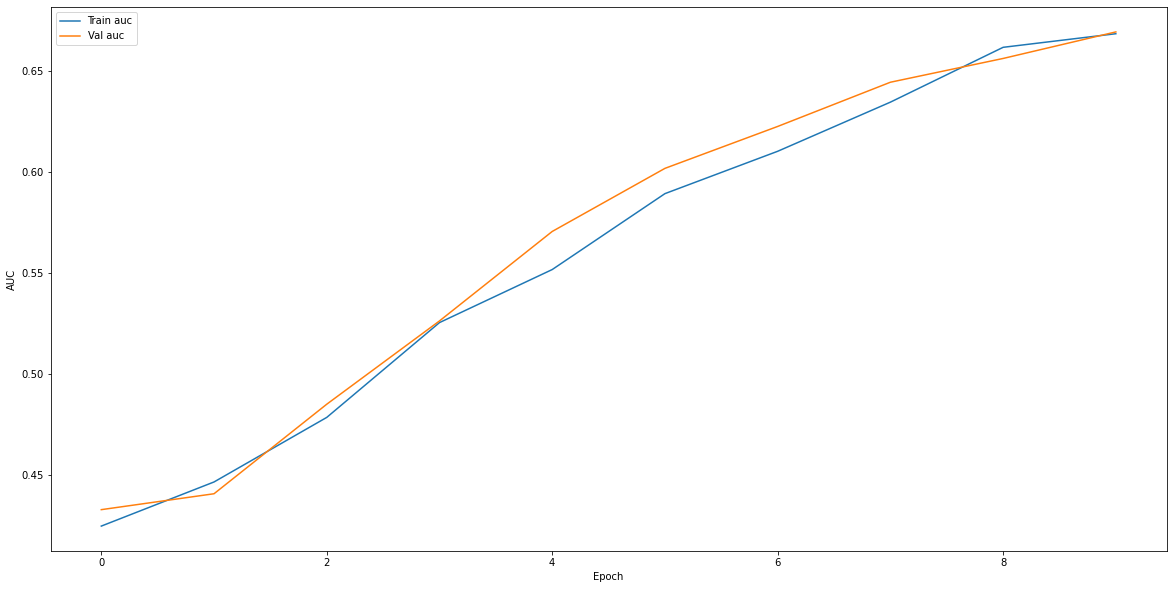

In [39]:
model = keras.Sequential([
        layers.Dense(6, activation='relu', input_shape=(train_data_sc.shape[1],)),  #[len(train['target'])]
        keras.layers.Dropout(0.2),
        layers.Dense(6, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)),
        layers.Dense(3, activation='relu'),   
        layers.Dense(1, activation='sigmoid')
      ])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='AUC')


EPOCHS = 10

history = model.fit(train_data_sc, y_train, epochs=EPOCHS, validation_split = 0.2, verbose=0, shuffle=True)

plt.rcParams['figure.figsize'] = [20, 10]
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.plot(hist['epoch'], hist['auc'], label='Train auc')
plt.plot(hist['epoch'], hist['val_auc'], label = 'Val auc')
plt.legend()

In [40]:
metrics['Keras'] = roc_auc_score(y_test, model.predict_proba(test_data_sc))
print(metrics['Keras'])


0.6803555355535553


In [41]:
metrics
#лучшие результаты у модели логистической регрессии

{'LR': 0.7874662466246625,
 'FR': 0.7856178474990355,
 'CatB': 0.7688938536710813,
 'Keras': 0.6803555355535553}